# Predict Snow Depth with TransformerModel

## 1. Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import Callback

from darts import TimeSeries
from darts.models import TransformerModel, BlockRNNModel
from darts.metrics import mae, mape
from darts.utils.likelihood_models import GaussianLikelihood

import optuna
#from optuna.integration import PyTorchLightningPruningCallback  ## -- causes error --> workaround suggested on  https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

## 2. Getting Started
## Import basic preprocessed training dataset | all features scaled, target (snow_depth) not scaled!

In [7]:
# get preprocessed csv (refer to notebook_Anita-Gei_get_preprocessed_data.ipynb for more info)

df = pd.read_csv('/home/anita/code/MadMax1995bb/powder_alert2.0/raw_data/historical_data_preprocessed_snowdepth.csv')  #change path if necessary!
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns='Unnamed: 0')
df = df.set_index('date')
df.tail(2)

,snow_depth,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,pressure_msl,surface_pressure,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,1.23,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,-0.289634,-0.129623,-1.404447,...,-0.413650,-0.063053,-0.097270,-0.565147,-0.500000,0.866025,0.0,1.0,0.0,1.0
2024-01-01 23:00:00,1.23,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,-0.289634,-0.280686,-1.495166,...,-0.427446,-0.142219,-0.044957,-0.565147,-0.258819,0.965926,0.0,1.0,0.0,1.0


## 3. Create Time Series

In [8]:
feature_columns = df.drop(columns=['snow_depth']).columns.tolist()

snowdepth_series = TimeSeries.from_dataframe(df, value_cols='snow_depth')
feature_series = TimeSeries.from_dataframe(df, value_cols=feature_columns)

## 4. Split into Train, Validation and Test Sets

In [9]:
y_train_val, y_test = snowdepth_series.split_before(0.8)
y_train, y_val = y_train_val.split_before(0.8)

X_train_val, X_test = feature_series.split_before(0.8)
X_train, X_val = X_train_val.split_before(0.8)

## 5. TransformerModel without Optimization

In [6]:
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
callbacks = [early_stopper]

pl_trainer_kwargs ={
        "callbacks": callbacks,
    }

new_model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=100,  # stopped after epoch 15 with es
    pl_trainer_kwargs=pl_trainer_kwargs)

In [ ]:
new_model.fit(series=y_train, past_covariates=X_train, val_series=y_val, val_past_covariates=X_val, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.003. Signaling Trainer to stop.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=64, n_epochs=100, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7b9a5efb1270>]})

### 5.1 Save Initial TransformerModel

In [ ]:
new_model.save('/content/snow_depth_model_1.pt')

   -----------------------------------------------------------------------------

### 5.2 Load Initial TransformerModel

In [27]:
loaded_model_1 = TransformerModel.load('/home/anita/code/MadMax1995bb/powder_alert2.0/models/snow_depth/snow_depth_model_1.pt')

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

### 5.3 Predict Test Data with Initial TransformerModel

In [28]:
forecast_test48h = loaded_model_1.predict(n=48, series=y_train_val, past_covariates=X_train_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
forecast_test48h.values()

array([[0.9166504 ],
       [0.91651427],
       [0.91763704],
       [0.91739297],
       [0.91760078],
       [0.91934583],
       [0.91969401],
       [0.92094861],
       [0.92301323],
       [0.92456152],
       [0.92718892],
       [0.92663534],
       [0.9286992 ],
       [0.93020679],
       [0.93179403],
       [0.93385039],
       [0.93671479],
       [0.93914202],
       [0.93988239],
       [0.94177533],
       [0.94111546],
       [0.94211855],
       [0.94263282],
       [0.9436318 ],
       [0.94543821],
       [0.94569478],
       [0.94674942],
       [0.94815157],
       [0.94882901],
       [0.94889109],
       [0.94988814],
       [0.950289  ],
       [0.95033397],
       [0.95194112],
       [0.952622  ],
       [0.95255938],
       [0.9530358 ],
       [0.95418537],
       [0.95464273],
       [0.95568884],
       [0.95788795],
       [0.95857194],
       [0.96048188],
       [0.96140365],
       [0.9650528 ],
       [0.96579539],
       [0.96573119],
       [0.966

### 5.4 Evaluate Model Performance | MAE | Historical Forecasting & Backtesting of Initial TransformerModel

In [35]:
mae_new = mae(snowdepth_series.slice_intersect(forecast_test48h), forecast_test48h)
print(f"MAE on y_test = {round(mae_new,2)} m")

MAE on y_test = 0.06 m


In [38]:
historical_forecast_new = loaded_model_1.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowdepth_series.slice_intersect(historical_forecast_new), historical_forecast_new)
print(f"Historical Forecast MAE = {round(error_mae,2)} m")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Historical Forecast MAE = 0.03 m


In [1]:
snowdepth_series.plot(label="Actual Snow Depth")
historical_forecast_new.plot(label="Historical Forecast")
plt.legend()
plt.show();

NameError: name 'snowdepth_series' is not defined

In [ ]:
backtest_mae_new = loaded_model_1.backtest(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae_new} m")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest MAE: 0.024497823196316836


## 6. Load Currently Best Model

In [10]:
loaded_model = TransformerModel.load("/home/anita/code/MadMax1995bb/powder_alert2.0/models/snowdepth/snow_depth_model_1.pt")

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Current MAE for historical forecast = 0.03 m


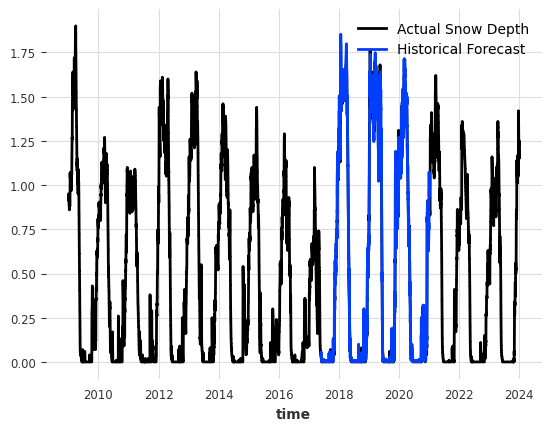

In [11]:
historical_forecast_loaded = loaded_model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowdepth_series.slice_intersect(historical_forecast_loaded), historical_forecast_loaded)
print(f"Current MAE for historical forecast = {round(error_mae, 2)} m")

snowdepth_series.plot(label="Actual Snow Depth")
historical_forecast_loaded.plot(label="Historical Forecast")
plt.legend()
plt.show();

In [12]:
backtest_mae_loaded = loaded_model.backtest(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    metric=mae,
    verbose=True
)

print(f"Currently best backtesting MAE = {round(backtest_mae_loaded, 2)} m")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Currently best backtesting MAE = 0.02 m


## 7. Model Optimization - Improving Model Performance | Target = snow_depth
IDEAS

### 7.1 Additional Time Features

In [ ]:
# Create lag features for snow depth and precipitation
lags = [1, 3]
for lag in lags:
    df[f'snow_depth_lag_{lag}'] = df['snow_depth'].shift(lag)
    df[f'precipitation_lag_{lag}'] = df['precipitation'].shift(lag)

df.tail()

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2022-03-14 08:00:00,0.0,3.0,-0.144176,-2.126533,-1.118233,-0.389763,-0.272938,1.178280,1.368418,0.994678,...,0.866025,-0.500000,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 09:00:00,0.0,2.0,0.042154,-2.360580,-1.099278,-0.389763,-0.272938,1.178280,1.318064,1.079167,...,0.707107,-0.707107,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 10:00:00,0.0,1.0,0.192421,-2.493189,-1.055049,-0.389763,-0.272938,1.178280,1.267709,1.138710,...,0.500000,-0.866025,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 11:00:00,0.0,3.0,0.246517,-1.929069,-0.619078,-0.389763,-0.272938,1.159507,1.255121,1.164308,...,0.258819,-0.965926,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 12:00:00,0.0,1.0,0.438858,-2.839331,-1.111915,-0.389763,-0.272938,1.159507,1.129235,1.190595,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.389763,0.0,-0.389763


In [ ]:
# Add rolling statistics
df['cloud_cover_rolling_mean_3h'] = df['cloud_cover'].rolling(window=3).mean()
df['precipitation_rolling_std_3h'] = df['precipitation'].rolling(window=3).std()
df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3,cloud_cover_rolling_mean_3h,precipitation_rolling_std_3h
date,,,,,,,,,,,,,,,,,,,,,
2022-03-14 11:00:00,0.0,3.0,0.246517,-1.929069,-0.619078,-0.389763,-0.272938,1.159507,1.255121,1.164308,...,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763,-0.232365,0.0
2022-03-14 12:00:00,0.0,1.0,0.438858,-2.839331,-1.111915,-0.389763,-0.272938,1.159507,1.129235,1.190595,...,NaN,NaN,NaN,NaN,0.0,-0.389763,0.0,-0.389763,-0.485142,0.0


In [ ]:
# Drop rows with NaN values (introduced by lags and rolling)
df = df.dropna()
print(df.shape)

(115689, 34)


### 7.2 Use Subset of Data while finding the "best" Model!

In [ ]:
train_df = df[-30000:]
print(train_df.shape)
train_df.tail(2)

(30000, 28)


,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,-0.413650,-0.063053,-0.097270,-0.565147,-0.500000,0.866025,0.0,1.0,0.0,1.0
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,-0.427446,-0.142219,-0.044957,-0.565147,-0.258819,0.965926,0.0,1.0,0.0,1.0


### 7.3 Hyperparameter Optimization with Optuna  
==> Initial Optimization doesn't improve Performance ==> stick to model1

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
# Workaround to get PyTorchLightningPruningCallback working

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [15]:
def objective(trial):
    d_model = trial.suggest_categorical("d_model", [128, 256, 512])
    nhead = trial.suggest_categorical("nhead", [4, 8])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_encoder_layers = trial.suggest_categorical("num_encoder_layers", [2, 3, 6])
    num_decoder_layers = trial.suggest_categorical("num_decoder_layers", [2, 3, 6])
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [256, 512, 1024])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
    callbacks = [pruner, early_stopper]

    pl_trainer_kwargs = {
        "accelerator": "auto", # gpu only on Colab!
        #"devices": -1,
        "callbacks": callbacks,
    }

    # reproducibility
    torch.manual_seed(42)

    # build the Transformer model
    snowdepth_model_opt = TransformerModel(
        input_chunk_length=48,
        output_chunk_length=48,
        batch_size=batch_size,
        n_epochs=100,
        nr_epochs_val_period=1,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        pl_trainer_kwargs=pl_trainer_kwargs,
        likelihood=GaussianLikelihood(),
        model_name="snowdepth_transformer_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # train the model
    snowdepth_model_opt.fit(
        series=y_train,
        past_covariates=X_train,
        val_series=y_val,
        val_past_covariates=X_val,
    )

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint("snowdepth_transformer_model")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = snowdepth_model_opt.predict(series=y_train, n=48)
    maes = mae(y_val[:48], preds, verbose=True)
    mae_val = np.mean(maes)

    return mae_val if mae_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the maes on the validation set
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, callbacks=[print_callback]) # increase trials to e.g. 20

[I 2024-12-18 23:06:27,953] A new study created in memory with name: no-name-d91e6efc-5cc4-4735-8b96-4fdf35dddf42
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: -1.554


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: -1.554. Signaling Trainer to stop.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you d

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-19 03:03:13,470] Trial 0 finished with value: 0.0012569430544860734 and parameters: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.0003073105347310985}. Best is trial 0 with value: 0.0012569430544860734.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.0012569430544860734, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.0003073105347310985}
Best value: 0.0012569430544860734, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.0003073105347310985}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 7.4 K  | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 2.1 M  | train
8 | decoder             | Linear              | 24.7 K | train
--------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.574     Total estimated model params 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.976


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.741 >= min_delta = 0.001. New best score: 0.236


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.119 >= min_delta = 0.001. New best score: 0.117


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.638 >= min_delta = 0.001. New best score: -0.521


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: -0.521. Signaling Trainer to stop.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you d

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-19 07:24:09,945] Trial 1 finished with value: 0.0495802863031281 and parameters: {'d_model': 256, 'nhead': 4, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0068847394433167435}. Best is trial 0 with value: 0.0012569430544860734.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.0495802863031281, Current params: {'d_model': 256, 'nhead': 4, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0068847394433167435}
Best value: 0.0012569430544860734, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.0003073105347310985}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 3.7 K  | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 2.2 M  | train
8 | decoder             | Linear              | 12.4 K | train
--------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.779     Total estimated model params 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: -0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: -0.964


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.237 >= min_delta = 0.001. New best score: -1.202


Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2024-12-19 08:26:21,946] Trial 2 failed with parameters: {'d_model': 128, 'nhead': 8, 'dropout': 0.3, 'batch_size': 32, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.00013295639353906632} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 574, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 981, in _run
    results = self._run_stage()
  File "/home/an

NameError: name 'exit' is not defined

In [16]:
# Print best parameters
print(study.best_value)
print(f"Best trial: {study.best_trial.params}")  # best params after 3 trials

0.0012569430544860734
Best trial: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.0003073105347310985}


#### 7.3.1 Initialize Model with optimized Parameters

In [20]:
##fill after completing optuna study!

##use number of epochs from optimization
#early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
#callbacks = [early_stopper]

#pl_trainer_kwargs ={
        #"accelerator": "gpu", #only on Colab!
        #"devices": -1,
        #"callbacks": callbacks,
#    }


##best value: 0.0012569430544860734,
## Best params: {
    ## 'd_model': 256,
    ## 'nhead': 8,
    ## 'dropout': 0.2,
    ## 'batch_size': 64,
    ## 'num_encoder_layers': 2,
    ## 'num_decoder_layers': 3,
    ## 'dim_feedforward': 1024,
    ## 'lr': 0.0003073105347310985}
improved_model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=13,  # derived from optimization
    nr_epochs_val_period=1,
    dropout=0.2,
    optimizer_kwargs={"lr": 0.0003073105347310985},
    num_encoder_layers=2,
    num_decoder_layers=3,
    d_model=256,
    nhead=8,
    dim_feedforward=1024,
    pl_trainer_kwargs=pl_trainer_kwargs,
    likelihood=GaussianLikelihood(),
    model_name="opt_snowdepth_model",
    force_reset=True,
    random_state=42
    )

#### Fit Optimized Model - on whole dataset!

In [21]:
improved_model.fit(
    series=y_train,
    past_covariates=X_train,
    val_series=y_val,
    val_past_covariates=X_val,
    verbose=True
)

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 7.4 K  | train
6 | positional_encoding | _PositionalEncoding | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: -1.159


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.185 >= min_delta = 0.001. New best score: -1.344


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=13` reached.


TransformerModel(output_chunk_shift=0, d_model=256, nhead=8, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=1024, dropout=0.2, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=64, n_epochs=13, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.0003073105347310985}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11d48b3700>]}, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), model_name=opt_snowdepth_model, force_reset=True, random_state=42)

#### 7.3.2 Evaluate Optimized Model Performance

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Validation MAE = 0.07718355177166529


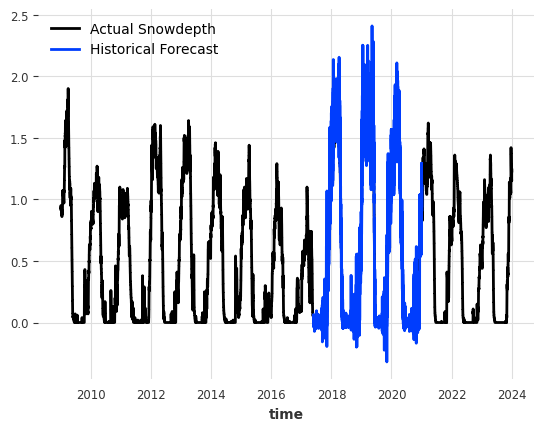

In [43]:
historical_forecast_improved = improved_model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowdepth_series.slice_intersect(historical_forecast_improved), historical_forecast_improved)
print(f"Validation MAE = {error_mae}")

snowdepth_series.plot(label="Actual Snowdepth")
historical_forecast_improved.plot(label="Historical Forecast")
plt.legend()
plt.show();

In [23]:
backtest_mae_improved = improved_model.backtest(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae_improved} m")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest MAE: 0.07088799371007626


#### 7.3.3 Save Optimized Model

In [24]:
current_dir = os.getcwd()
relative_path = os.path.join(os.path.dirname(current_dir),'models/snow_depth')
file_name = "optimized_snowdepth_model.pt"
file_path = os.path.join(relative_path, file_name)

improved_model.save(file_path)

## 8. Compare to Baseline Model MAE

In [25]:
from darts.models import NaiveSeasonal
from darts.metrics import mae

base_model = NaiveSeasonal(K=12)

base_model.fit(y_train_val)

# Forecast on the test data
forecast = base_model.predict(len(y_test))

# Calculate the Mean Absolute Error (MAE)
base_mae = mae(y_test, forecast)

print(f"Naive Model MAE: {base_mae:.2f} m")

Naive Model MAE: 0.55 m


In [42]:
if base_mae > backtest_mae_loaded:
    print(f"Current TransformerModel, with MAE = {round(backtest_mae_loaded, 2)} outperforms Baseline MAE ({base_mae:.2f} meters) by {round(base_mae-backtest_mae_loaded, 3)} meters")
elif base_mae < backtest_mae_loaded:
    print(f"Baseline Model, with MAE = {round(base_mae, 2)} outperforms current TransformerModel MAE ({backtest_mae_loaded:.2f} meters) by {round(base_mae-backtest_mae_loaded, 3)} meters")

Current TransformerModel, with MAE = 0.02 outperforms Baseline MAE (0.55 meters) by 0.522 meters


## 9. Predict Current Values with Currently Best Model

### 9.1 Get Current Prediction Data

In [ ]:
# load preprocessed prediction data - check notebook notebook_Anita-Gei_snowdepth_predictions_and_processing

current_data = pd.read_csv('/home/anita/code/MadMax1995bb/powder_alert2.0/raw_data/preprocessed_prediction_data_snowdepth.csv', parse_dates=['date'], usecols=lambda col: col != '')
if 'Unnamed: 0' in current_data.columns:
    current_data = current_data.drop(columns=['Unnamed: 0'])
current_data['date'] = pd.to_datetime(current_data['date'])
current_data.tail()


,date,snow_depth,temperature_2m,weather_code_encoded,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,pressure_msl,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
91,2024-12-21 03:00:00,0.31,3.0,-1.328636,-1.406396,-1.871851,-0.389763,-0.272938,-0.289634,0.952995,...,0.893662,0.442197,-0.044957,-0.695403,1.000000,1.000000e+00,-1.378444,-0.314556,-0.702752,1.230262
92,2024-12-21 04:00:00,0.30,3.0,-1.292572,-1.697717,-1.980508,-0.389763,-0.272938,-0.289634,0.915223,...,0.826849,0.362503,0.216608,-0.695403,1.224745,7.071068e-01,-1.378444,-0.314556,-0.702752,1.230262
93,2024-12-21 05:00:00,0.30,3.0,-1.256508,-1.814246,-2.006791,-0.389763,-0.272938,-0.289634,0.877466,...,0.870720,0.462255,0.268922,-0.695403,1.366025,3.660254e-01,-1.378444,-0.314556,-0.702752,1.230262
94,2024-12-21 06:00:00,0.30,3.0,-1.220444,-1.814246,-1.971758,-0.389763,-0.272938,-0.289634,0.864881,...,0.905992,0.535494,0.321235,-0.695403,1.414214,1.651050e-16,-1.378444,-0.314556,-0.702752,1.230262
95,2024-12-21 07:00:00,0.30,3.0,-1.414288,-1.872510,-2.191364,-0.389763,-0.272938,-0.289634,1.217352,...,0.255146,0.215587,0.556644,-0.695403,1.366025,-3.660254e-01,-1.378444,-0.314556,-0.702752,1.230262


In [64]:
current_data.shape

(96, 29)

In [65]:
pred_df = current_data.head(48) #take last 48 hours as input for prediction

In [66]:
pred_feature_columns = pred_df.drop(columns=['date','snow_depth']).columns.to_list()

actual_snowdepth_series = TimeSeries.from_dataframe(current_data[['date','snow_depth']], 'date', 'snow_depth')
pred_snowdepth_series = TimeSeries.from_dataframe(pred_df, time_col='date', value_cols='snow_depth')
pred_feature_series = TimeSeries.from_dataframe(pred_df, time_col='date', value_cols=pred_feature_columns)

In [75]:
pred48h = loaded_model.predict(n=48, series=pred_snowdepth_series, past_covariates=pred_feature_series)
pred48h.values()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.50567311],
       [0.49824755],
       [0.4962773 ],
       [0.49092933],
       [0.48547357],
       [0.48427586],
       [0.48230847],
       [0.48204824],
       [0.48513698],
       [0.48363475],
       [0.49095585],
       [0.48812837],
       [0.49595537],
       [0.49996039],
       [0.50363491],
       [0.5133018 ],
       [0.51965425],
       [0.52961934],
       [0.53399888],
       [0.54383479],
       [0.55026104],
       [0.55672143],
       [0.56512276],
       [0.57767619],
       [0.58884293],
       [0.59684839],
       [0.60477989],
       [0.61571933],
       [0.62445899],
       [0.63137013],
       [0.64043351],
       [0.6489146 ],
       [0.65654189],
       [0.66929595],
       [0.67512874],
       [0.68387045],
       [0.69119229],
       [0.70027298],
       [0.707172  ],
       [0.71490269],
       [0.72280586],
       [0.72899999],
       [0.73678027],
       [0.74071466],
       [0.75108435],
       [0.75674738],
       [0.75958272],
       [0.766

In [76]:
current_pred_mae = mae(actual_snowdepth_series.slice_intersect(pred48h), pred48h)
current_pred_mae

0.3503369037910053

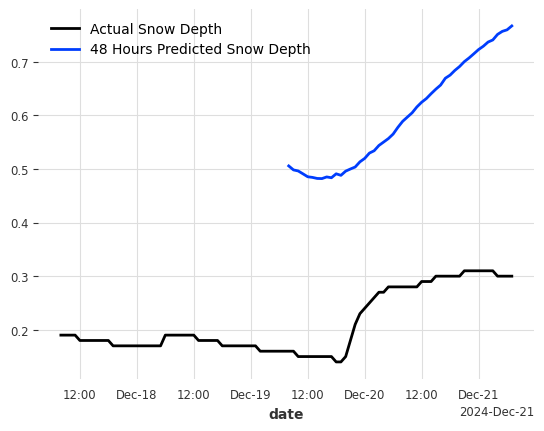

In [77]:
actual_snowdepth_series.plot(label="Actual Snow Depth")
pred48h.plot(label="48 Hours Predicted Snow Depth")
plt.legend()
plt.show();

## 10. Retrain Currently Best Model
[ Future Task ]

In [ ]:
loaded_model.backtest(
    series= # full target series with new data (eventually exclude a test_set),
    past_covariates=# full feature series with new data (eventually exclude a test_set),
    start=0.7,
    forecast_horizon=48,
    stride=1, # choose appropriate stride for computation reasons! e.g. every few years
    retrain=True,
    metric=mae,
    verbose=True
)

print(f"Best backtesting MAE after retraining = {round(backtest_mae_loaded, 2)} m")